In [3]:
import pandas as pd

# Dataset load
df = pd.read_csv("heart_disease.csv")  

# Target variable distribution check
print(df["Heart Disease Status"].value_counts())
print("\nClass ratio (percentage):")
print(df["Heart Disease Status"].value_counts(normalize=True) * 100)


Heart Disease Status
No     8000
Yes    2000
Name: count, dtype: int64

Class ratio (percentage):
Heart Disease Status
No     80.0
Yes    20.0
Name: proportion, dtype: float64


In [7]:
# =============================
# Step 0: Handle Missing Values
# =============================
from sklearn.impute import SimpleImputer

df_clean = df.copy()

# Categorical columns fill with mode
for col in df_clean.select_dtypes(include=['object']).columns:
    if col != "Heart Disease Status":
        imputer = SimpleImputer(strategy="most_frequent")
        df_clean[col] = imputer.fit_transform(df_clean[[col]]).ravel()

# Numeric columns fill with median
for col in df_clean.select_dtypes(include=['int64', 'float64']).columns:
    imputer = SimpleImputer(strategy="median")
    df_clean[col] = imputer.fit_transform(df_clean[[col]]).ravel()


# =============================
# Step 1: Encode categorical
# =============================
from sklearn.preprocessing import LabelEncoder

df_encoded = df_clean.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != "Heart Disease Status":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

# Encode target
df_encoded["Heart Disease Status"] = df_encoded["Heart Disease Status"].map({"No": 0, "Yes": 1})

# =============================
# Step 2: Train-Test Split
# =============================
from sklearn.model_selection import train_test_split

X = df_encoded.drop("Heart Disease Status", axis=1)
y = df_encoded["Heart Disease Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================
# Step 3: Logistic Regression
# =============================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# =============================
# Step 4: Evaluation
# =============================
y_pred = log_reg.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1600    0]
 [ 400    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1600
           1       0.00      0.00      0.00       400

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\

In [8]:
# =============================
# Balanced Logistic Regression with Scaling
# =============================
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with class_weight balanced
log_reg_bal = LogisticRegression(max_iter=2000, random_state=42, class_weight="balanced")
log_reg_bal.fit(X_train_scaled, y_train)

# Predictions
y_pred_bal = log_reg_bal.predict(X_test_scaled)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))


Confusion Matrix:
 [[835 765]
 [220 180]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.52      0.63      1600
           1       0.19      0.45      0.27       400

    accuracy                           0.51      2000
   macro avg       0.49      0.49      0.45      2000
weighted avg       0.67      0.51      0.56      2000



In [10]:
# Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("classifier", LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))])
lr_pipeline.fit(X_train, y_train)

# Coefficients
lr_model = lr_pipeline.named_steps['classifier']
coef = lr_model.coef_[0]

# Feature names
feature_names = numerical_cols + list(lr_pipeline.named_steps['preprocessor']
                                      .named_transformers_['cat']
                                      .named_steps['onehot'].get_feature_names_out(categorical_cols))

for f, c in zip(feature_names, coef):
    print(f"{f}: {c:.4f}")



Age: -0.0386
Blood Pressure: -0.0127
Cholesterol Level: -0.0028
BMI: 0.0788
Sleep Hours: -0.0201
Triglyceride Level: -0.0046
Fasting Blood Sugar: -0.0169
CRP Level: 0.0005
Homocysteine Level: 0.0154
Gender_0: 0.0642
Gender_1: -0.0635
Exercise Habits_0: -0.0196
Exercise Habits_1: -0.0049
Exercise Habits_2: 0.0251
Smoking_0: -0.0209
Smoking_1: 0.0215
Family Heart Disease_0: 0.0116
Family Heart Disease_1: -0.0110
Diabetes_0: -0.0037
Diabetes_1: 0.0043
High Blood Pressure_0: 0.0058
High Blood Pressure_1: -0.0051
Low HDL Cholesterol_0: -0.0075
Low HDL Cholesterol_1: 0.0081
High LDL Cholesterol_0: -0.0260
High LDL Cholesterol_1: 0.0266
Alcohol Consumption_0: 0.0144
Alcohol Consumption_1: 0.0269
Alcohol Consumption_2: -0.0407
Stress Level_0: 0.0265
Stress Level_1: -0.1041
Stress Level_2: 0.0781
Sugar Consumption_0: 0.0612
Sugar Consumption_1: -0.0338
Sugar Consumption_2: -0.0268


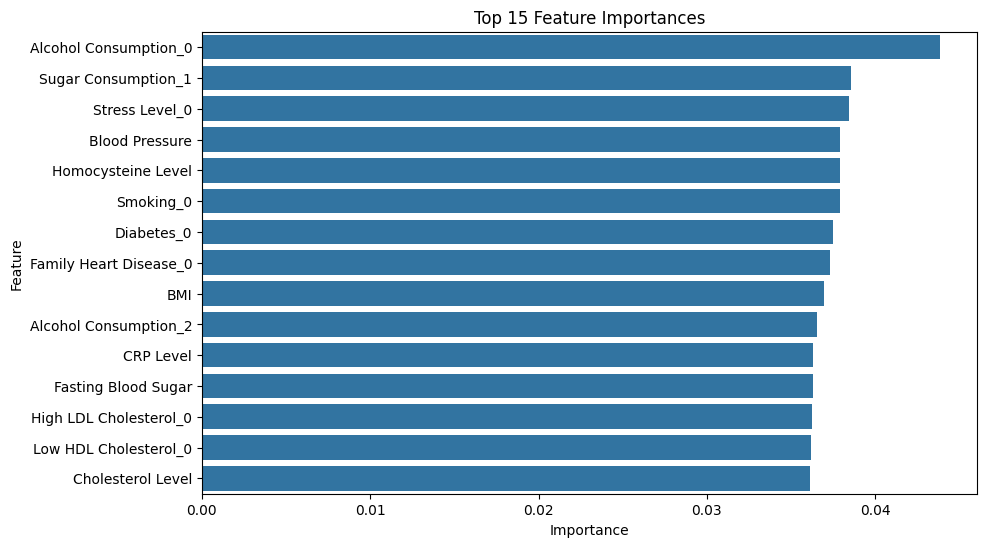

In [11]:
xgb_model = best_model.named_steps['classifier']  # XGBoost
importances = xgb_model.feature_importances_
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat']
                                      .named_steps['onehot'].get_feature_names_out(categorical_cols))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title("Top 15 Feature Importances")
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [2, 3, 4],
    'classifier__learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)


Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:33:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


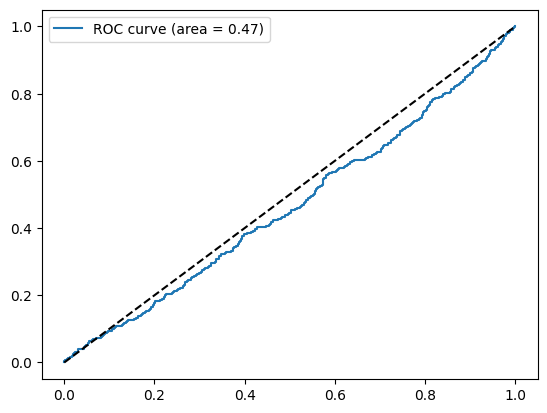

In [13]:
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# ROC Curve example
y_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.show()


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:42:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Performance Comparison:

                     Accuracy  Precision  Recall        F1   ROC-AUC
Logistic Regression    0.5085   0.189563  0.4450  0.265870  0.476205
Random Forest          0.7995   0.000000  0.0000  0.000000  0.528620
SVM                    0.7090   0.192568  0.1425  0.163793  0.514606
XGBoost                0.7735   0.126761  0.0225  0.038217  0.500241


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:42:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Confusion Matrix:
 [[1538   62]
 [ 391    9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87      1600
           1       0.13      0.02      0.04       400

    accuracy                           0.77      2000
   macro avg       0.46      0.49      0.45      2000
weighted avg       0.66      0.77      0.70      2000



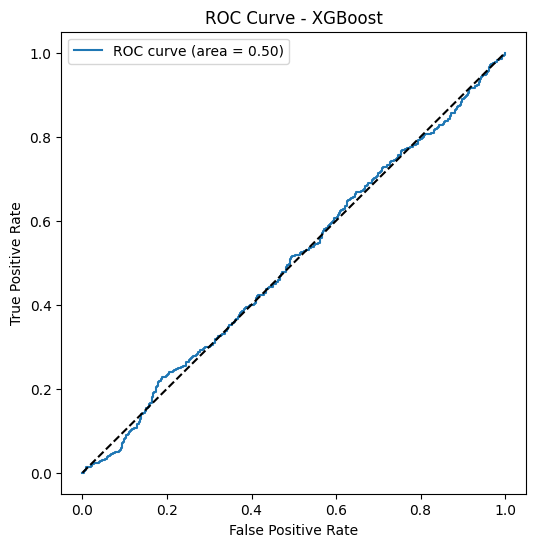


Logistic Regression Coefficients:
Age: -0.0353
Blood Pressure: -0.0128
Cholesterol Level: 0.0096
BMI: 0.1182
Sleep Hours: -0.0247
Triglyceride Level: -0.0100
Fasting Blood Sugar: -0.0469
CRP Level: 0.0068
Homocysteine Level: 0.0056
Gender_Female: 0.0505
Gender_Male: -0.0528
Exercise Habits_High: -0.0298
Exercise Habits_Low: -0.0020
Exercise Habits_Medium: 0.0295
Smoking_No: -0.0351
Smoking_Yes: 0.0328
Family Heart Disease_No: 0.0086
Family Heart Disease_Yes: -0.0109
Diabetes_No: -0.0094
Diabetes_Yes: 0.0071
High Blood Pressure_No: 0.0178
High Blood Pressure_Yes: -0.0201
Low HDL Cholesterol_No: -0.0123
Low HDL Cholesterol_Yes: 0.0100
High LDL Cholesterol_No: -0.0435
High LDL Cholesterol_Yes: 0.0412
Alcohol Consumption_High: 0.0295
Alcohol Consumption_Low: -0.0402
Alcohol Consumption_Medium: 0.0084
Stress Level_High: 0.0403
Stress Level_Low: -0.1129
Stress Level_Medium: 0.0703
Sugar Consumption_High: 0.0844
Sugar Consumption_Low: -0.0523
Sugar Consumption_Medium: -0.0343


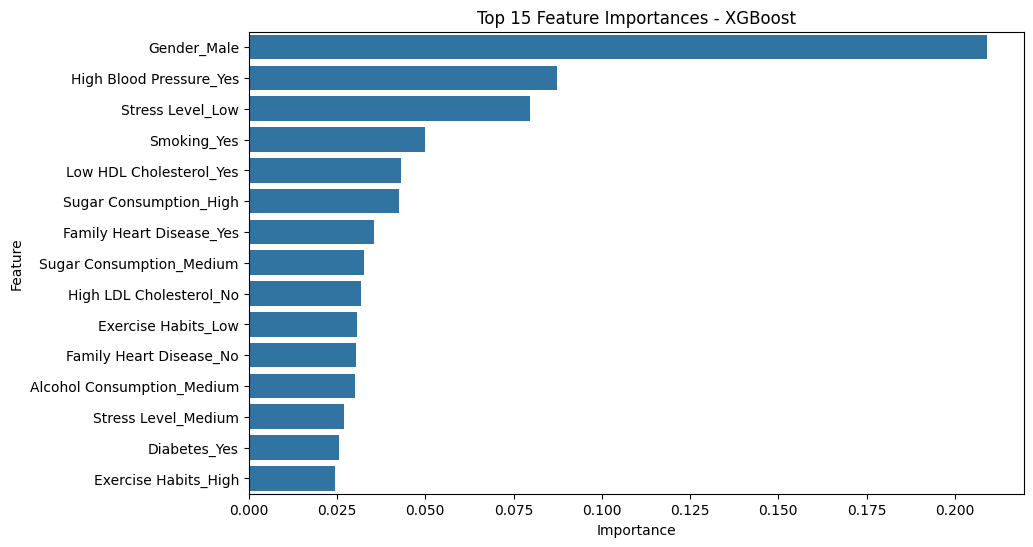


Best model pipeline saved as 'heart_disease_model_smote_pipeline.pkl'.


In [17]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
)

from imblearn.over_sampling import SMOTE

# ==============================
# 2. Load Dataset
# ==============================
df = pd.read_csv("heart_disease.csv")

# Target encode
X = df.drop("Heart Disease Status", axis=1)
y = df["Heart Disease Status"].map({"Yes":1, "No":0})

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# ==============================
# 3. Preprocessing Pipelines
# ==============================
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numerical_cols),
        ("cat", cat_transformer, categorical_cols)
    ]
)

# ==============================
# 4. Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 5. Preprocess training data first (to numeric matrix)
# ==============================
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ==============================
# 6. Handle Class Imbalance with SMOTE
# ==============================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)

# ==============================
# 7. Models
# ==============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

# ==============================
# 8. Train & Evaluate
# ==============================
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:,1]
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

# ==============================
# 9. Results
# ==============================
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:\n")
print(results_df)

# ==============================
# 10. Confusion Matrix & ROC Curve for best model (XGBoost)
# ==============================
best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train_res, y_train_res)
y_pred_best = best_model.predict(X_test_processed)
y_proba_best = best_model.predict_proba(X_test_processed)[:,1]

cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, zero_division=0))

fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

# ==============================
# 11. Feature Importance / Coefficients
# ==============================
# Logistic Regression coefficients
lr_model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_res, y_train_res)
coef = lr_model.coef_[0]

feature_names = numerical_cols + list(preprocessor.named_transformers_['cat']
                                      .named_steps['onehot'].get_feature_names_out(categorical_cols))
print("\nLogistic Regression Coefficients:")
for f, c in zip(feature_names, coef):
    print(f"{f}: {c:.4f}")

# XGBoost Feature Importance
importances = best_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()

# ==============================
# 12. Save the best model (with preprocessor) as a pipeline
# ==============================
from sklearn.pipeline import make_pipeline
final_pipeline = make_pipeline(preprocessor, best_model)
joblib.dump(final_pipeline, "heart_disease_model_smote_pipeline.pkl")
print("\nBest model pipeline saved as 'heart_disease_model_smote_pipeline.pkl'.")


In [19]:
print(X.columns.tolist())

['Age', 'Gender', 'Blood Pressure', 'Cholesterol Level', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'BMI', 'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 'Sleep Hours', 'Sugar Consumption', 'Triglyceride Level', 'Fasting Blood Sugar', 'CRP Level', 'Homocysteine Level']


In [24]:
import pandas as pd
import joblib

# Load saved pipeline
pipeline = joblib.load("heart_disease_model_smote_pipeline.pkl")

# Columns
numeric_cols = ['Age', 'Blood Pressure', 'Cholesterol Level', 'BMI', 'Sleep Hours',
                'Triglyceride Level', 'Fasting Blood Sugar', 'CRP Level', 'Homocysteine Level']

categorical_cols = ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes',
                    'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol',
                    'Alcohol Consumption', 'Stress Level', 'Sugar Consumption']

all_columns = numeric_cols + categorical_cols

# Example patient
new_patient_values = [
    55, 140, 250, 27, 7, 150, 0, 3.5, 12,         # numeric
    'Male', 'Regular', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Medium', 'Low'  # categorical
]

new_patient = pd.DataFrame([new_patient_values], columns=all_columns)

# Preprocess + predict
preprocessor = pipeline.named_steps['columntransformer']
model = pipeline.named_steps['xgbclassifier']

X_new_processed = preprocessor.transform(new_patient)

probability = model.predict_proba(X_new_processed)[:,1][0]
prediction = model.predict(X_new_processed)[0]

print(f"Predicted probability: {probability:.2f}")
print(f"Predicted class: {'Yes' if prediction==1 else 'No'}")


Predicted probability: 0.02
Predicted class: No


In [ ]:
# Check pipeline steps
print(pipeline.steps)


[('columntransformer', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Blood Pressure', 'Cholesterol Level',
                                  'BMI', 'Sleep Hours', 'Triglyceride Level',
                                  'Fasting Blood Sugar', 'CRP Level',
                                  'Homocysteine Level']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Exercise Habits', 'Smoking',
                                  'Family Heart Disease', 'Diabetes',
 